#### Иморитирование библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Библиотеки успешно загружены!")

Библиотеки успешно загружены!


#### Загрузка и анализ данных

Размер данных: (260640, 10)
Первые 5 строк:
   index    Date     Time  Global_active_power  Global_reactive_power  \
0      0  1/1/07  0:00:00                2.580                  0.136   
1      1  1/1/07  0:01:00                2.552                  0.100   
2      2  1/1/07  0:02:00                2.550                  0.100   
3      3  1/1/07  0:03:00                2.550                  0.100   
4      4  1/1/07  0:04:00                2.554                  0.100   

   Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0   241.97              10.6             0.0             0.0             0.0  
1   241.75              10.4             0.0             0.0             0.0  
2   241.64              10.4             0.0             0.0             0.0  
3   241.71              10.4             0.0             0.0             0.0  
4   241.98              10.4             0.0             0.0             0.0  

В наборе 'Потребление электроэнергии': 263

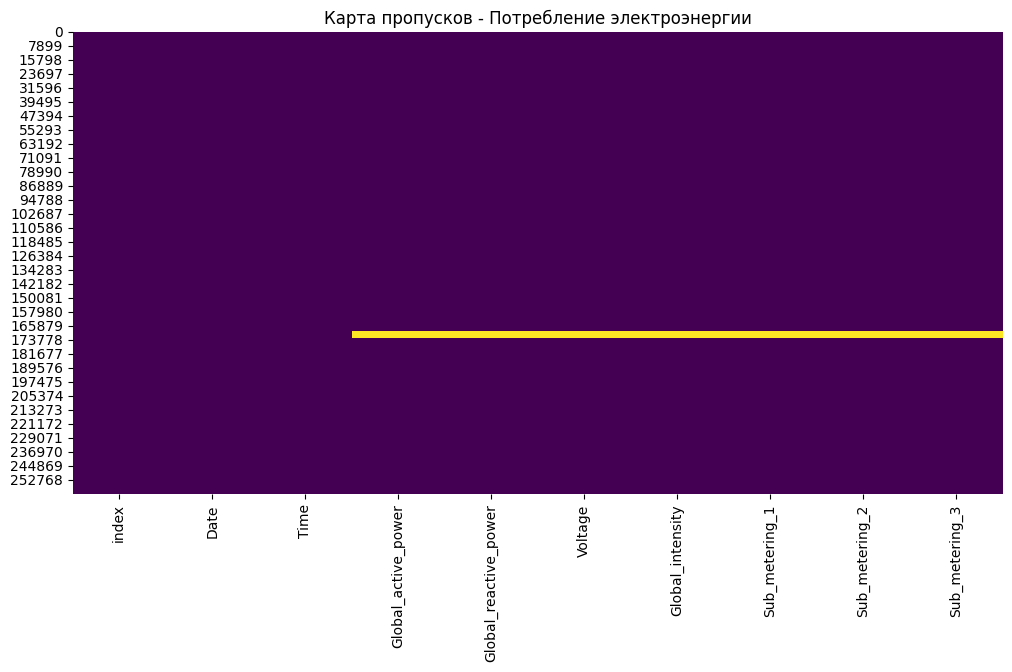

In [2]:
# Загрузка данных с обработкой пропусков
df = pd.read_csv('df/isxod.csv', 
                 na_values=['?'],  # помечаем '?' как пропуски
                 low_memory=False)

print(f"Размер данных: {df.shape}")
print(f"Первые 5 строк:")
print(f"{df.head()}\n")

# Анализ пропусков
def analyze_missing_data(dataframe, name):
    missing_total = dataframe.isnull().sum().sum()
    missing_percent = (missing_total / (dataframe.shape[0] * dataframe.shape[1])) * 100
    print(f"В наборе '{name}': {missing_total} пропусков ({missing_percent:.2f}%)")
    
    # Визуализация пропусков
    plt.figure(figsize=(12, 6))
    sns.heatmap(dataframe.isnull(), cbar=False, cmap='viridis')
    plt.title(f"Карта пропусков - {name}")
    plt.show()

analyze_missing_data(df, "Потребление электроэнергии")

#### Предобработка 

In [3]:
# Обработка пропусков 

# Проверяем пропуски до обработки
print(f"Пропуски до обработки: {df.isnull().sum().sum()}\n")

# Заполняем пропуски разными стратегиями для разных типов данных
for column in df.columns:
    if df[column].dtype in ['float64', 'int64']:
        # Для числовых - медианой (устойчива к выбросам)
        df[column] = df[column].fillna(df[column].median())
        print(f"Числовой столбец '{column}' заполнен медианой")

print(f"\nПропуски после обработки: {df.isnull().sum().sum()}")

Пропуски до обработки: 26397

Числовой столбец 'index' заполнен медианой
Числовой столбец 'Global_active_power' заполнен медианой
Числовой столбец 'Global_reactive_power' заполнен медианой
Числовой столбец 'Voltage' заполнен медианой
Числовой столбец 'Global_intensity' заполнен медианой
Числовой столбец 'Sub_metering_1' заполнен медианой
Числовой столбец 'Sub_metering_2' заполнен медианой
Числовой столбец 'Sub_metering_3' заполнен медианой

Пропуски после обработки: 0


В наборе 'Потребление электроэнергии': 0 пропусков (0.00%)


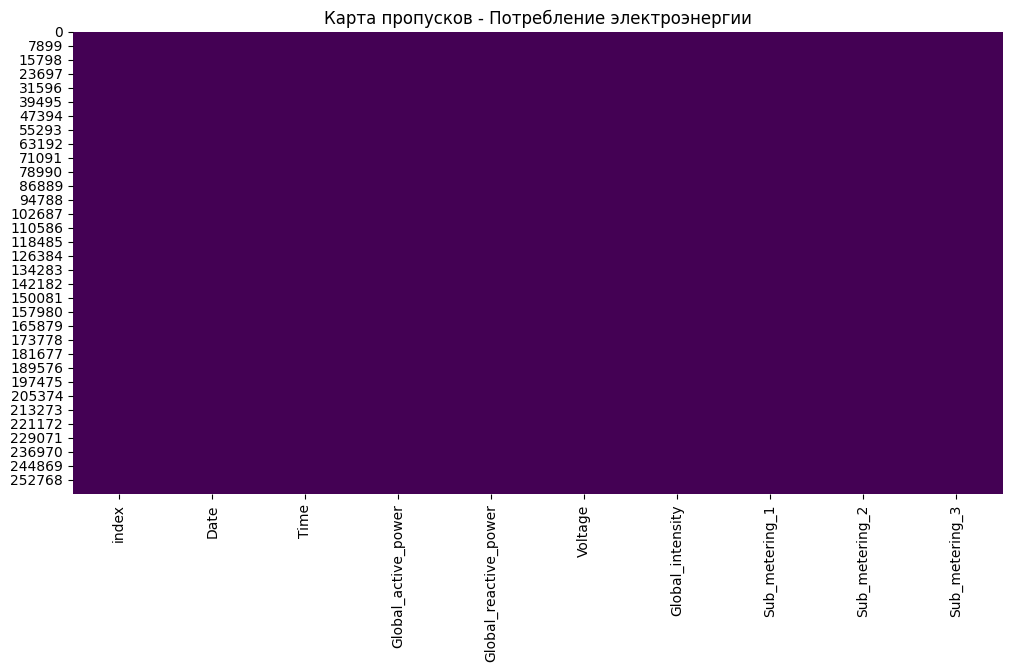

In [4]:
analyze_missing_data(df, "Потребление электроэнергии")

In [5]:
# Создаем datetime индекс
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.set_index('datetime')

# Удаляем исходные столбцы даты и времени
df = df.drop(['Date', 'Time'], axis=1)

# Удаляем столбец 'index' - теперь datetime индекс
df = df.drop('index', axis=1)

print("Временной индекс datetime создан")
print(f"Диапазон данных: от {df.index.min()} до {df.index.max()}")

Временной индекс datetime создан
Диапазон данных: от 2007-01-01 00:00:00 до 2007-12-06 23:59:00


In [6]:
# Создаем признаки времени (важно для сезонности)

df['hour'] = df.index.hour # (0-23)
# Пример: 
# 0 = полночь, 12 = полдень, 18 = 6 вечера
# Нужен чтобы модель понимала "ночные провалы" и "дневные пики"
# Зачем: Энергопотребление сильно зависит от времени суток


df['day_of_week'] = df.index.dayofweek # (0-6)
# 0 = понедельник, 1 = вторник, ..., 6 = воскресенье
# В данных: [0 3 6 1 4 2 5] - это просто порядок дней
# Зачем: Потребление в выходные отличается от рабочих дней


df['month'] = df.index.month # (1-12)
# 1 = январь, 12 = декабрь
# Зимой - отопление, летом - кондиционеры
# Зачем: Учесть сезонные изменения (отопление/кондиционирование)


df['is_weekend'] = (df.index.dayofweek >= 5).astype(int) # (0 или 1)
# 0 = рабочий день, 1 = суббота/воскресенье
# Упрощенная версия day_of_week
# Зачем: Быстро выделить выходные дни


print("Временные признаки созданы:")
print(f"Часы: {df['hour'].unique()}")
print(f"Дни недели: {df['day_of_week'].unique()}")

Временные признаки созданы:
Часы: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Дни недели: [0 3 6 1 4 2 5]


In [7]:
df.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,month,is_weekend
datetime,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,0,0,1,0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,0,0,1,0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,0,0,1,0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,0,0,1,0
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0,0,0,1,0


In [8]:
# Сохраняем обработанные данные
df.to_csv('df/obr.csv')
print("Обработанные данные сохранены в 'df/obr.csv'")

# Также сохраним sample для проверки
sample_df = df.sample(300)  # 300 случайных строк
sample_df.to_csv('df/obr_sample.csv')
print("Sample данных сохранен в 'df/obr_sample.csv'")

# Проверим размер сохраненных данных
print(f"\nРазмер полного датасета: {df.shape}")
print(f"Размер sample: {sample_df.shape}")

Обработанные данные сохранены в 'df/obr.csv'
Sample данных сохранен в 'df/obr_sample.csv'

Размер полного датасета: (260640, 11)
Размер sample: (300, 11)


#### Анализ

📊 Статистика по временным признакам:
Часы: от 0 до 23
Дни недели: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6)]
Месяцы: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]
Выходные: is_weekend
0    187200
1     73440
Name: count, dtype: int64


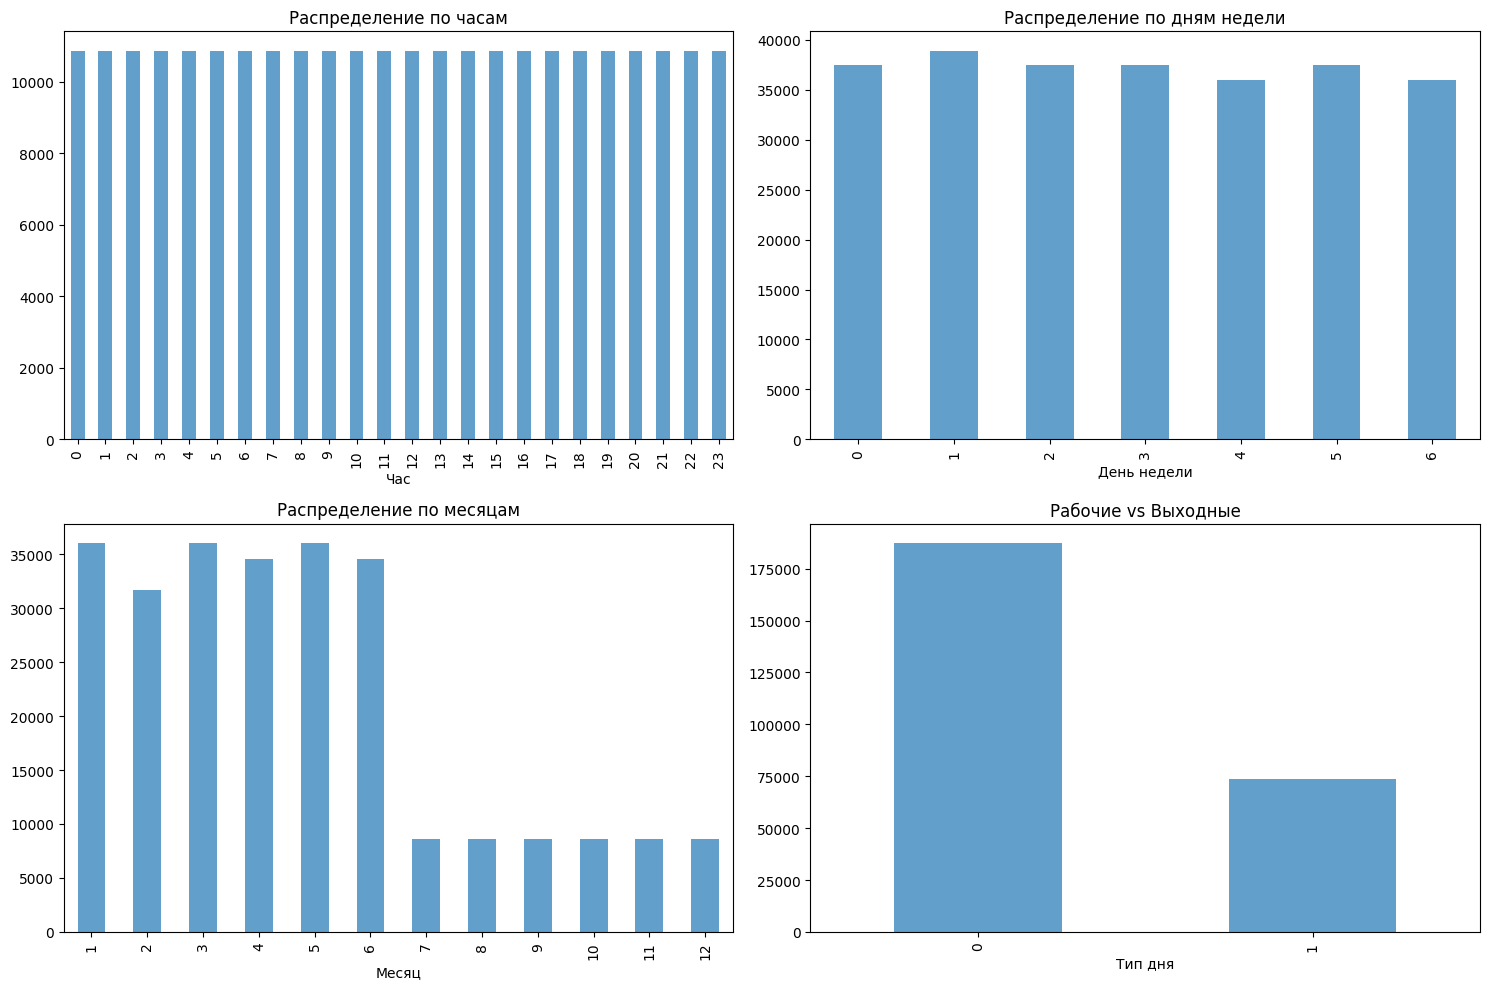

In [9]:
print("📊 Статистика по временным признакам:")
print(f"Часы: от {df['hour'].min()} до {df['hour'].max()}")
print(f"Дни недели: {sorted(df['day_of_week'].unique())}")
print(f"Месяцы: {sorted(df['month'].unique())}")
print(f"Выходные: {df['is_weekend'].value_counts()}")

# Визуализируем распределение
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
df['hour'].value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Распределение по часам')
plt.xlabel('Час')

plt.subplot(2, 2, 2)
df['day_of_week'].value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Распределение по дням недели')
plt.xlabel('День недели')

plt.subplot(2, 2, 3)
df['month'].value_counts().sort_index().plot(kind='bar', alpha=0.7)
plt.title('Распределение по месяцам')
plt.xlabel('Месяц')

plt.subplot(2, 2, 4)
df['is_weekend'].value_counts().plot(kind='bar', alpha=0.7)
plt.title('Рабочие vs Выходные')
plt.xlabel('Тип дня')

plt.tight_layout()
plt.show()


Анализ целевой переменной (Global_active_power):
Среднее потребление: 1.16 кВт
Максимальное потребление: 10.67 кВт
Минимальное потребление: 0.08 кВт
Количество записей: 260640


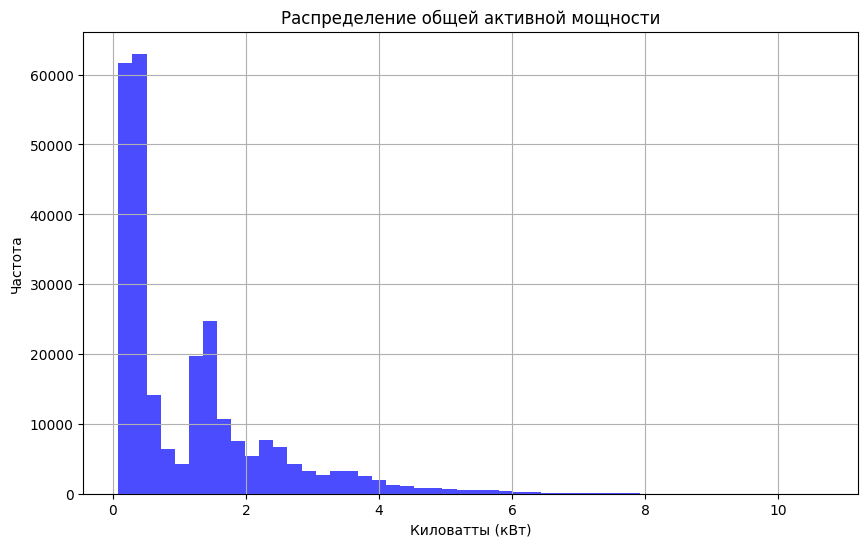

In [10]:
# Анализируем целевую переменную
print(f"\nАнализ целевой переменной (Global_active_power):")
print(f"Среднее потребление: {df['Global_active_power'].mean():.2f} кВт")
print(f"Максимальное потребление: {df['Global_active_power'].max():.2f} кВт") 
print(f"Минимальное потребление: {df['Global_active_power'].min():.2f} кВт")
print(f"Количество записей: {len(df)}")

# Визуализируем распределение
plt.figure(figsize=(10, 6))
plt.hist(df['Global_active_power'].dropna(), bins=50, alpha=0.7, color='blue')
plt.title('Распределение общей активной мощности')
plt.xlabel('Киловатты (кВт)')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Анализ суточной сезонности:


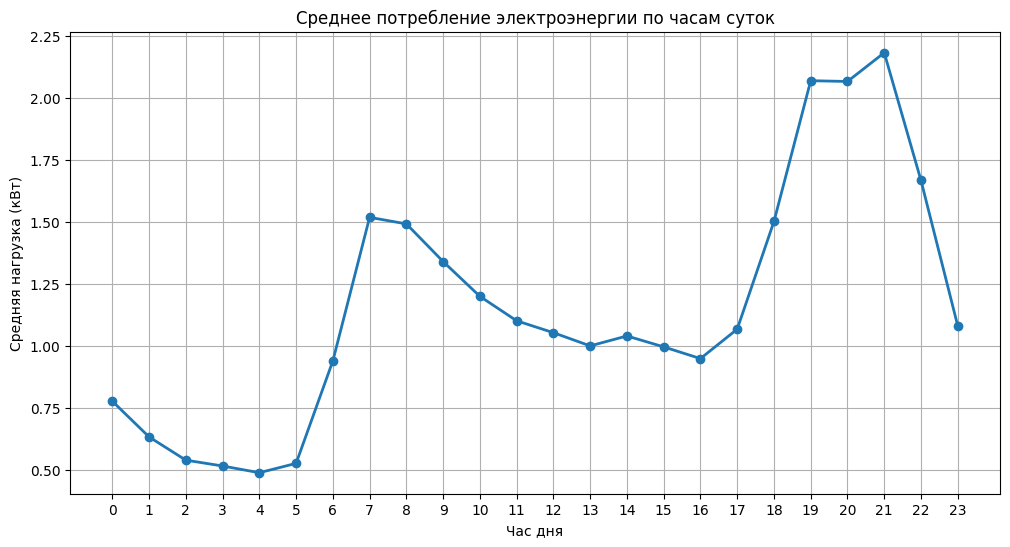

Наблюдения по суточной сезонности:
Минимальное потребление: 0.49 кВт в 4:00
Максимальное потребление: 2.18 кВт в 21:00


In [11]:
# Анализ суточной сезонности
print("Анализ суточной сезонности:")

# Группируем по часам и считаем среднюю нагрузку
hourly_pattern = df.groupby('hour')['Global_active_power'].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o', linewidth=2)
plt.title('Среднее потребление электроэнергии по часам суток')
plt.xlabel('Час дня')
plt.ylabel('Средняя нагрузка (кВт)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

print("Наблюдения по суточной сезонности:")
print(f"Минимальное потребление: {hourly_pattern.min():.2f} кВт в {hourly_pattern.idxmin()}:00")
print(f"Максимальное потребление: {hourly_pattern.max():.2f} кВт в {hourly_pattern.idxmax()}:00")